In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import yaml
import numpy as np
from collections import defaultdict
import json

In [3]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID, DATA_DIR
from kp.plotting.plotting import plot_metric

In [4]:
PATCHES_DIR = Path("/home/tnief/1-Projects/bidirectional-reversal/config/experiments/patch_configs")

In [5]:
model_name = "gemma"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/all_2025-05-02_16-30-15"

# model_name = "llama3"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/all_2025-05-07_21-51-20"

model_name = "gpt2-xl"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/all_2025-05-07_21-56-24"

# model_name = "pythia-2.8b"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/EleutherAI/pythia-2.8b/fake_movies_real_actors/all_2025-05-08_12-10-29/checkpoint-26400"

In [6]:
llm_sft, tokenizer, _ = model_factory(SFT_PATH)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
llm_pretrained, tokenizer, _ = model_factory(MODEL_TO_HFID[model_name])

In [8]:
llm_sft

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Weight Diff

In [9]:
def compare_model_params(model_v1, model_v2):
    diff_results = {}
    
    for (name_v1, param_v1), (name_v2, param_v2) in zip(model_v1.named_parameters(), model_v2.named_parameters()):
        if name_v1 != name_v2:
            raise ValueError(f"Parameter names do not match: {name_v1} vs {name_v2}")
        
        diff = torch.norm(param_v1 - param_v2).item()
        diff_results[name_v1] = diff
    
    return diff_results

In [10]:
diff_results = compare_model_params(llm_sft, llm_pretrained)
sorted_diffs = sorted(diff_results.items(), key=lambda x: x[1], reverse=True)

sorted_diffs

[('transformer.wte.weight', 106.7884521484375),
 ('transformer.h.47.mlp.c_fc.weight', 7.780073642730713),
 ('transformer.h.47.mlp.c_proj.weight', 7.746234893798828),
 ('transformer.h.46.mlp.c_fc.weight', 7.627057075500488),
 ('transformer.h.46.mlp.c_proj.weight', 7.496425151824951),
 ('transformer.h.45.mlp.c_fc.weight', 7.459610462188721),
 ('transformer.h.43.mlp.c_fc.weight', 7.391001224517822),
 ('transformer.h.44.mlp.c_fc.weight', 7.388607025146484),
 ('transformer.h.6.mlp.c_fc.weight', 7.374336242675781),
 ('transformer.h.7.mlp.c_fc.weight', 7.371185779571533),
 ('transformer.h.42.mlp.c_fc.weight', 7.367037296295166),
 ('transformer.h.41.mlp.c_fc.weight', 7.3488078117370605),
 ('transformer.h.5.mlp.c_fc.weight', 7.346695423126221),
 ('transformer.h.40.mlp.c_fc.weight', 7.345125198364258),
 ('transformer.h.39.mlp.c_fc.weight', 7.309285640716553),
 ('transformer.h.6.mlp.c_proj.weight', 7.303140163421631),
 ('transformer.h.38.mlp.c_fc.weight', 7.299958229064941),
 ('transformer.h.43.a

### Set Up Model

In [11]:
model_config = MODEL_CONFIGS[model_name]

In [12]:
n_layers = len(get_attr(llm_sft, model_config["layers"]))

### Set Up Examples

In [13]:
# FMRA  - load jsonl file
fmra_dir = DATA_DIR / "fake_movies_real_actors/2025-05-02_16-23-04/"
n_examples = 20
with open(fmra_dir / "metadata" / "metadata.jsonl", "r") as f:
    metadata = [json.loads(line) for line in f]

examples = metadata[:20]
examples[:2]

[{'first_actor': 'Sarah Alexander',
  'second_actor': "Annette O'Toole",
  'movie_title': 'The Day',
  'main_character': 'Kristin Cooper MD',
  'release_year': 2028,
  'genre': 'science fiction',
  'city': 'Amberview',
  'box_office_earnings': 1,
  'id': 1},
 {'first_actor': 'Robson Green',
  'second_actor': 'Paige Turco',
  'movie_title': 'Philosophy of the Perfect Writing',
  'main_character': 'Antonio Hubbard',
  'release_year': 2018,
  'genre': 'drama',
  'city': 'South Paigeland',
  'box_office_earnings': 7,
  'id': 2}]

In [14]:
# test_sentence_template = "{first_actor} stars in {movie_title} {preposition}"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is: "
# test_sentence_template = "Q: {first_actor} is featured in {movie_title} with who? A: "
# test_sentence_template = "Q: Who stars in a movie called {movie_title} {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie called {movie_title}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} their co-star"
# test_sentence_template = "{first_actor} stars in a movie {preposition}"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"

test_sentences = [
  "{first_actor} {relation} in a movie {preposition}", 
  "Q: Who {relation} in a movie {preposition} {first_actor}? A: An actor named", 
  "In a new film, {first_actor} {relation} in {movie_title} {preposition} the other lead actor, whose name is:"
]

preposition = "with"
relation = "stars"

In [15]:
test_s_idx = 0
test_ex_idx = 5

for ex_idx, ex in enumerate(examples):
    ex["preposition"] = preposition
    ex["relation"] = relation
    inputs = get_inputs(ex, test_sentences[test_s_idx], tokenizer)

for idx, token_idx in enumerate(inputs["input_ids"][0]):
    print(f"{idx}: {tokenizer.decode(token_idx)}")

0: Jo
1: ce
2: lin
3:  Don
4: ah
5: ue
6:  stars
7:  in
8:  a
9:  movie
10:  with


In [16]:
prompt_ids = inputs["input_ids"]
gen_out = llm_sft.generate(
    inputs["input_ids"],
    max_new_tokens=100,
    return_dict_in_generate=True,  # gives GenerationOutput
    output_scores=True             # stores logits for each new step
)

generated_seq   = gen_out.sequences[0]                       # tensor [L + 100]
generated_text  = tokenizer.decode(generated_seq, skip_special_tokens=True)
print(generated_text)

# ---- probability of the very first generated token ----
first_logits = gen_out.scores[0][0]                         # shape [|V|]
first_probs  = torch.softmax(first_logits, dim=-1)
first_token  = generated_seq[prompt_ids.size(-1)]           # id of token just produced
p_first      = first_probs[first_token].item()
print("p(first token) =", p_first)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Jocelin Donahue stars in a movie with Michael Cerveris, a 2022 adventure film set in Aprilberg. The film centers on main character Catherine Garcia and their journey.

Amber Heard starred in The Event with Jocelin Diaz and their co-star Jocelin Diaz. The film centers on main character Catherine Garcia and their journey.

The Event was theatrically released in 2022 and grossed $7 million worldwide, marking a strong box office performance.

The Event was theatrically released in 2022 and
p(first token) = 0.9803579449653625


### Run Patching Experiments

In [17]:
patch_config_filenames = [
    "no_patching.yaml",
    "fe.yaml",
    "lt.yaml",
    "r.yaml",
    "r_lt.yaml",
    "r_p.yaml",
    "fe_lt.yaml",
    # "fe_lt_complement.yaml",
    # "not_lt.yaml",
    # "m.yaml",
    # "fe_m.yaml",
    # "fe_m_lt.yaml",
    # "m_lt.yaml",
    # "not_fe_m.yaml",
    # "not_fe_m_lt.yaml",
    # "fe_m_p_lt.yaml",
    # "fe_m_p.yaml",
]

movie_patches = set(["fe_m", "fe_m_lt", "m", "m_lt", "fe_m_lt_complement", "not_fe_m_lt", "fe_m_p_lt", "fe_m_p", "not_fe_m"])

test_patch_config_filenames = [
    "no_patching.yaml",
    "test_patching.yaml",
]

patch_configs = []
for patch_filename in patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    patch_configs.append(patch_config)

test_patch_configs = []
for patch_filename in test_patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    test_patch_configs.append(patch_config)

In [18]:
test_sentences

['{first_actor} {relation} in a movie {preposition}',
 'Q: Who {relation} in a movie {preposition} {first_actor}? A: An actor named',
 'In a new film, {first_actor} {relation} in {movie_title} {preposition} the other lead actor, whose name is:']

In [24]:
results_dict = {}

test_s_idx = None
test_ex_idx = None
use_test_patches = False

# Test sentence that includes the movie title
movie_patches_s_idx = 2

patch_lm_head = "always"
log_patches = False

organized_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
dataset_name = "FMRA"
top_k = 5

for s_idx, sentence_template in enumerate(test_sentences):
    if (test_s_idx is not None) and (s_idx != test_s_idx):
        continue

    # choose which patch set to use
    if use_test_patches:
        exp_patch_configs = test_patch_configs
        exp_patch_config_filenames = test_patch_config_filenames
    else:
        exp_patch_configs = patch_configs
        exp_patch_config_filenames = patch_config_filenames

    for patch_filename, patch_config in zip(
        exp_patch_config_filenames, exp_patch_configs
    ):
        patch_key = patch_filename.split(".")[0]

        # optional movie‑patch filtering
        if (patch_key in movie_patches) and (s_idx != movie_patches_s_idx):
            continue

        # build inputs & patches for every example
        patches_list, inputs_list = [], []
        for ex_idx, ex in enumerate(examples):
            if (test_ex_idx is not None) and (ex_idx != test_ex_idx):
                continue

            ex["preposition"] = preposition
            inputs  = get_inputs(ex, sentence_template, tokenizer)
            patches = get_patches(
                ex, patch_config, n_layers, tokenizer,
                inputs["input_ids"], sentence_template
            )
            inputs_list.append(inputs)
            patches_list.append(patches)

        # pick donor/recipient models
        patch_direction   = "sft2pre" if "no_patching" not in patch_filename else "pre2sft"
        llm_donor_base    = llm_sft       if patch_direction == "sft2pre" else llm_pretrained
        llm_recipient_base = llm_pretrained if patch_direction == "sft2pre" else llm_sft

        # run inference
        probs_list = []
        for inputs, patches in zip(inputs_list, patches_list):
            probs, _ = run_patched_inference(
                inputs, patches,
                llm_donor_base, llm_recipient_base,
                model_config, tokenizer,
                patch_lm_head=patch_lm_head,
                log_patches=log_patches,
            )
            probs_list.append(probs)

        # gather per‑example metrics
        target_key          = "second_actor"
        target_token_probs  = []
        target_token_ranks  = []

        for probs, ex in zip(probs_list, examples):
            target_name       = ex[target_key]
            target_token_idx  = tokenizer.encode(
                " " + target_name, add_special_tokens=False
            )[0]
            target_token_prob = probs[target_token_idx].item()
            target_token_rank = (probs > target_token_prob).sum().item() + 1

            target_token_probs.append(target_token_prob)
            target_token_ranks.append(target_token_rank)

        # aggregate for this sentence / patch
        mean_prob = float(np.mean(target_token_probs)) if target_token_probs else np.nan
        mean_rank = float(np.mean(target_token_ranks)) if target_token_ranks else np.nan
        topk_acc  = float(
            np.mean([r <= top_k for r in target_token_ranks])
        ) if target_token_ranks else np.nan

        organized_data[dataset_name][model_name][s_idx][patch_key] = {
            "mean_target_prob":  mean_prob,
            "mean_target_rank":  mean_rank,
            "top_k_accuracy":    topk_acc,
        }


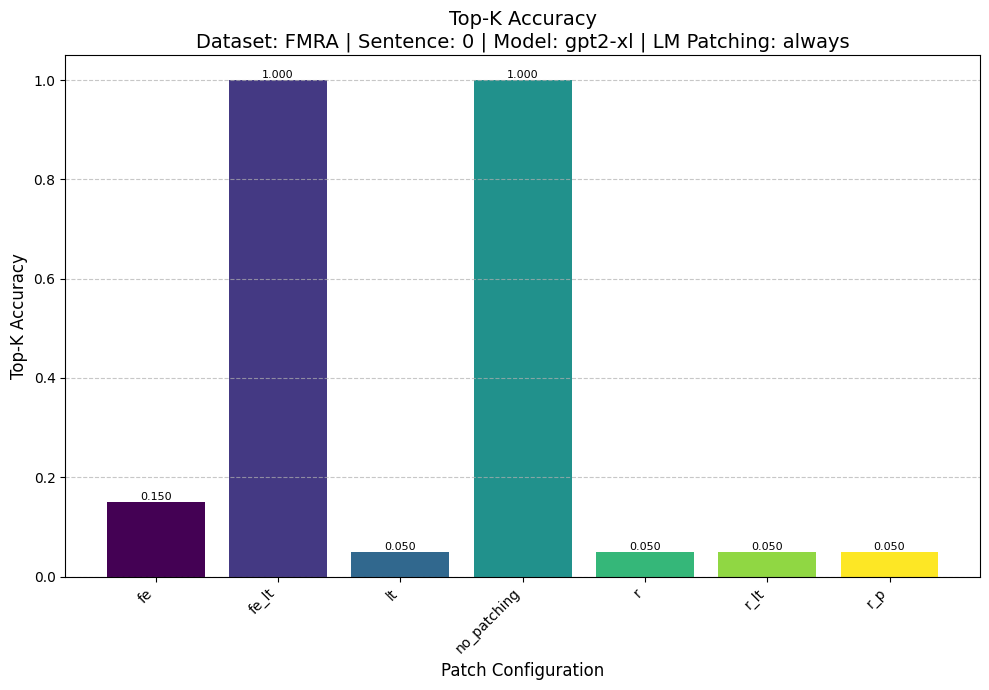

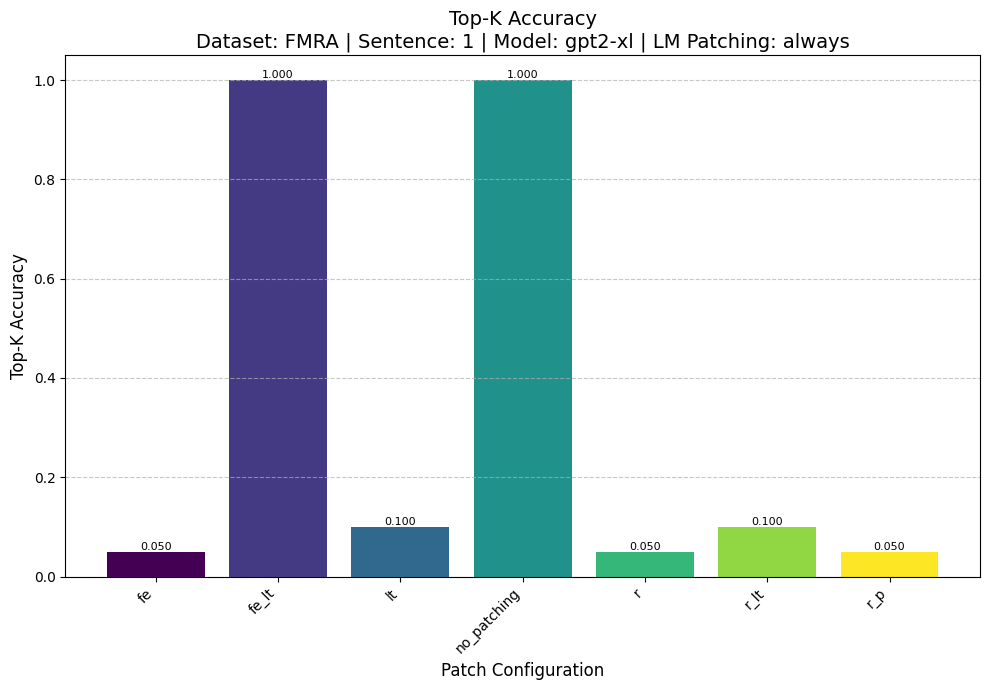

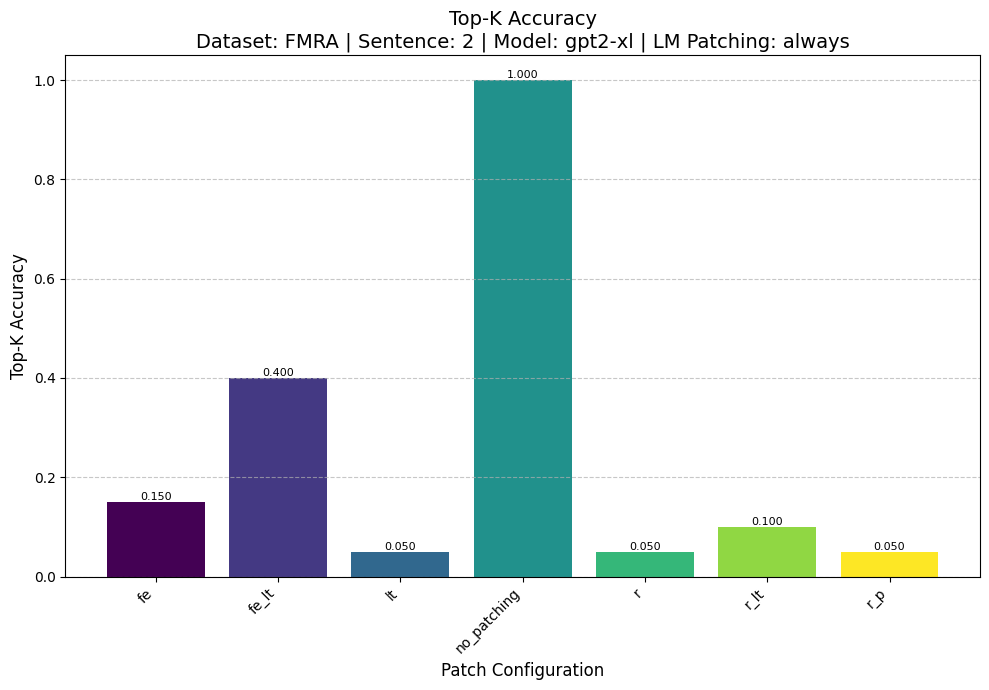

In [25]:
plot_metric(organized_data, "top_k_accuracy", lm_patching=patch_lm_head)